In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import plotly.express as px

import shap


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
data_path = r'Data_collection/main_data/Modified_Apple_iPhones_with_all_columns_end.xlsx'

In [3]:
df = pd.read_excel(data_path)

In [4]:
df.head()

,Year,Apple iPhone model,review,data source,Category,Sentiment Label,Apple annual revenue($bn),iPhone annual revenue($bn),iPhone annual sales(mm),Active iPhone units in US(mm),...,AirPod annual sales(mm),Mac annual revenue($bn),Mac annual sales(mm),Apple Services annual revenue($bn),Number of subscribers to iOS apps(mm),Apple Pay annual transaction volume(bn),Apple Music annual subscribers(mm),Apple News active users(mm),No. of iPhone users(billion),iPhone’s Market Share(%)
0,2022,iPhone 14 series,iphon 14 plu havent actual plu name iphon ever...,Youtube,Camera,Positive,394.3,205.4,232.2,1332,...,82,40.0,26.1,78.0,900,650,88,125,1.36,48.7
1,2022,iPhone 14 series,addit also enhanc light sensit dynam rang,Blogs,General,Positive,394.3,205.4,232.2,1332,...,82,40.0,26.1,78.0,900,650,88,125,1.36,48.7
2,2022,iPhone 14 series,iphon 14 pro pro max come dual rear camera,Blogs,Camera,Neutral,394.3,205.4,232.2,1332,...,82,40.0,26.1,78.0,900,650,88,125,1.36,48.7
3,2022,iPhone 14 series,primari camera 12mp sensor secondari camera 12...,Blogs,Camera,Neutral,394.3,205.4,232.2,1332,...,82,40.0,26.1,78.0,900,650,88,125,1.36,48.7
4,2022,iPhone 14 series,resolut ident iphon 13 pro howev main camera i...,Blogs,Camera,Positive,394.3,205.4,232.2,1332,...,82,40.0,26.1,78.0,900,650,88,125,1.36,48.7


In [5]:
list(df.columns)

['Year',
 'Apple iPhone model',
 'review',
 'data source',
 'Category',
 'Sentiment Label',
 'Apple annual revenue($bn)',
 'iPhone annual revenue($bn)',
 'iPhone annual sales(mm)',
 'Active iPhone units in US(mm)',
 'iPad annual revenue($bn)',
 'iPad annual sales(mm)',
 'Wearable, Home and Accessories annual revenue($bn)',
 'Apple Watch annual sales($bn)',
 'AirPod annual sales(mm)',
 'Mac annual revenue($bn)',
 'Mac annual sales(mm)',
 'Apple Services annual revenue($bn)',
 'Number of subscribers to iOS apps(mm)',
 'Apple Pay annual transaction volume(bn)',
 'Apple Music annual subscribers(mm)',
 'Apple News active users(mm)',
 'No. of iPhone users(billion)',
 'iPhone’s Market Share(%)']

In [6]:
sales_df = df[['Year','iPhone annual sales(mm)','AirPod annual sales(mm)']]
sales_df = sales_df.drop_duplicates().reset_index(drop=True)
sales_df

,Year,iPhone annual sales(mm),AirPod annual sales(mm)
0,2022,232.2,82
1,2021,242.0,85
2,2020,196.9,114
3,2019,187.2,60
4,2018,217.7,35


## Create a sales target variable

In [7]:
sales_df = df[['Year','iPhone annual sales(mm)']]
sales_df = sales_df.drop_duplicates().reset_index(drop=True)
sales_df

,Year,iPhone annual sales(mm)
0,2022,232.2
1,2021,242.0
2,2020,196.9
3,2019,187.2
4,2018,217.7


In [8]:
# Sort the DataFrame by 'Year' in ascending order
sales_df = sales_df.sort_values(by='Year')

# Calculate the difference in sales compared to the previous year
sales_df['Sales_Diff'] = sales_df['iPhone annual sales(mm)'].diff()

# Create a new column 'Sales_Status' based on the sales difference
sales_df['Sales_Status'] = sales_df['Sales_Diff'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# Drop the 'Sales_Diff' column if you don't need it
sales_df = sales_df.drop('Sales_Diff', axis=1)

# Reset the index if needed
sales_df = sales_df.reset_index(drop=True)

# Display the resulting DataFrame
sales_df

,Year,iPhone annual sales(mm),Sales_Status
0,2018,217.7,0
1,2019,187.2,-1
2,2020,196.9,1
3,2021,242.0,1
4,2022,232.2,-1


## Merge this sales different to the main df as target variable

In [9]:
df = df.merge(sales_df[['Year', 'Sales_Status']], on='Year', how='left')


In [10]:
df.head()

,Year,Apple iPhone model,review,data source,Category,Sentiment Label,Apple annual revenue($bn),iPhone annual revenue($bn),iPhone annual sales(mm),Active iPhone units in US(mm),...,Mac annual revenue($bn),Mac annual sales(mm),Apple Services annual revenue($bn),Number of subscribers to iOS apps(mm),Apple Pay annual transaction volume(bn),Apple Music annual subscribers(mm),Apple News active users(mm),No. of iPhone users(billion),iPhone’s Market Share(%),Sales_Status
0,2022,iPhone 14 series,iphon 14 plu havent actual plu name iphon ever...,Youtube,Camera,Positive,394.3,205.4,232.2,1332,...,40.0,26.1,78.0,900,650,88,125,1.36,48.7,-1
1,2022,iPhone 14 series,addit also enhanc light sensit dynam rang,Blogs,General,Positive,394.3,205.4,232.2,1332,...,40.0,26.1,78.0,900,650,88,125,1.36,48.7,-1
2,2022,iPhone 14 series,iphon 14 pro pro max come dual rear camera,Blogs,Camera,Neutral,394.3,205.4,232.2,1332,...,40.0,26.1,78.0,900,650,88,125,1.36,48.7,-1
3,2022,iPhone 14 series,primari camera 12mp sensor secondari camera 12...,Blogs,Camera,Neutral,394.3,205.4,232.2,1332,...,40.0,26.1,78.0,900,650,88,125,1.36,48.7,-1
4,2022,iPhone 14 series,resolut ident iphon 13 pro howev main camera i...,Blogs,Camera,Positive,394.3,205.4,232.2,1332,...,40.0,26.1,78.0,900,650,88,125,1.36,48.7,-1


## Lets start the feature filtering & engineering 

In [11]:
columns_to_select = [
 'data source',
 'Category',
 'Sentiment Label',
 'Apple annual revenue($bn)',
 'Active iPhone units in US(mm)',
 'iPad annual revenue($bn)',
 'iPad annual sales(mm)',
 'Wearable, Home and Accessories annual revenue($bn)',
 'Apple Watch annual sales($bn)',
 'AirPod annual sales(mm)',
 'Mac annual revenue($bn)',
 'Mac annual sales(mm)',
 'Apple Services annual revenue($bn)',
 'Number of subscribers to iOS apps(mm)',
 'Apple Pay annual transaction volume(bn)',
 'Apple Music annual subscribers(mm)',
 'Apple News active users(mm)',
 'No. of iPhone users(billion)',
 'iPhone’s Market Share(%)']

In [12]:
X = df[columns_to_select]
y = df['Sales_Status']

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


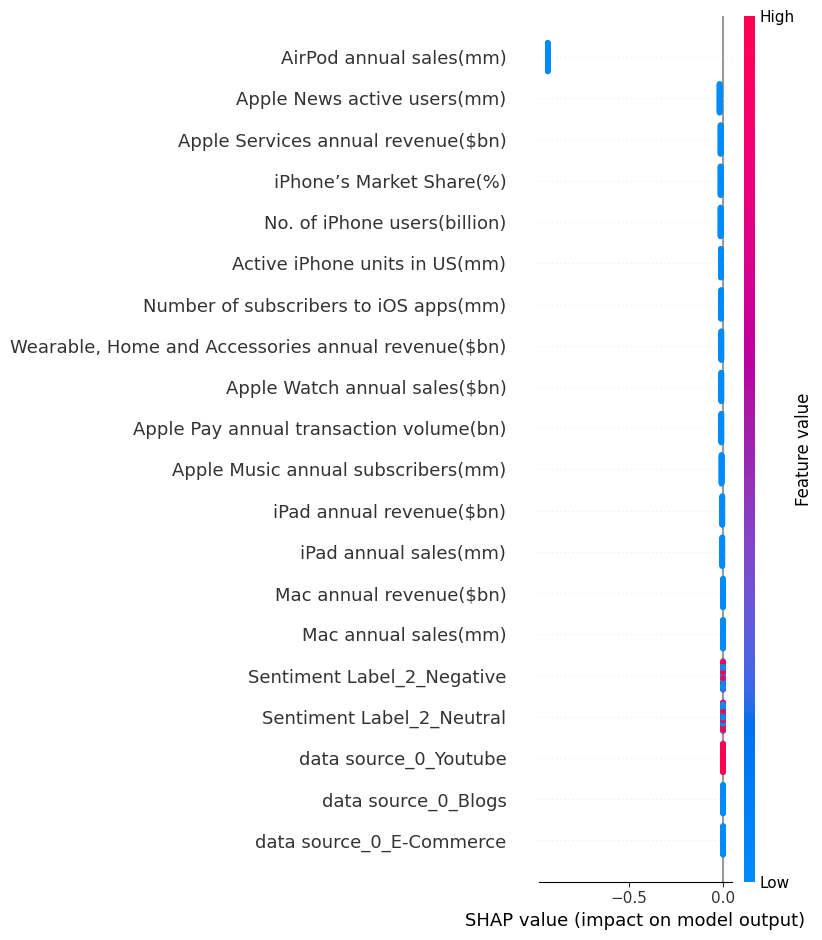

In [13]:

# Identify categorical columns (you can change this based on your dataset)
categorical_columns = ['data source', 'Category','Sentiment Label']


# Perform one-hot encoding for categorical variables
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
X_encoded = encoder.fit_transform(X[categorical_columns])

# Manually create column names for one-hot encoded features
encoded_column_names = []
for i, col in enumerate(categorical_columns):
    unique_values = X[col].unique()
    for val in unique_values:
        encoded_column_names.append(f'{col}_{i}_{val}')
        
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_column_names)

# Drop the original categorical columns from X
X = X.drop(categorical_columns, axis=1)

# Concatenate the one-hot encoded DataFrame with the original numerical features
X = pd.concat([X, X_encoded_df], axis=1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
# model = xgb.XGBRegressor() # Use XGBRegressor for regression tasks or XGBClassifier for classification
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Create a SHAP explainer for the model
explainer = shap.Explainer(model, X)

# Calculate SHAP values for a subset of your data (e.g., the first 100 rows)
shap_values = explainer(X.iloc[:100])

# Summary plot using Plotly
shap.summary_plot(shap_values, X.iloc[:100], show=False)



In [14]:
# Create a SHAP explainer for the model
explainer = shap.Explainer(model, X)

# Calculate SHAP values for the entire dataset
shap_values = explainer(X)

# Calculate the absolute mean SHAP values for each feature
mean_shap_values = abs(shap_values.values).mean(axis=0)

# Create a DataFrame to store feature names and their mean SHAP values
shap_summary = pd.DataFrame({'Feature': X.columns, 'Mean SHAP Value': mean_shap_values})

# Sort the DataFrame by mean SHAP values in descending order
shap_summary = shap_summary.sort_values(by='Mean SHAP Value', ascending=False)

# Print the sorted summary
print(shap_summary)

 99%|===================| 81504/82085 [00:34<00:00]        

                                              Feature  Mean SHAP Value
6                             AirPod annual sales(mm)         0.914348
13                        Apple News active users(mm)         0.026279
14                       No. of iPhone users(billion)         0.018770
15                           iPhone’s Market Share(%)         0.018770
9                  Apple Services annual revenue($bn)         0.018770
1                       Active iPhone units in US(mm)         0.016893
10              Number of subscribers to iOS apps(mm)         0.015016
5                       Apple Watch annual sales($bn)         0.013139
11            Apple Pay annual transaction volume(bn)         0.013139
4   Wearable, Home and Accessories annual revenue(...         0.013139
12                 Apple Music annual subscribers(mm)         0.011262
3                               iPad annual sales(mm)         0.005631
2                            iPad annual revenue($bn)         0.005631
26    